## Introduction: Merton Jump Diffusion (MJD) Model

The **Merton Jump Diffusion (MJD)** model, introduced by Robert C. Merton in 1976, extends the classical **Black–Scholes–Merton (BSM)** framework by incorporating *sudden discontinuous jumps* in asset prices in addition to the continuous diffusion process.  
While the BSM model assumes that log-returns follow a continuous Gaussian process with constant volatility, the MJD model accounts for rare but significant market movements — such as earnings announcements, macroeconomic shocks, or geopolitical events — that lead to abrupt price jumps.

### Mathematical Framework

In the MJD model, the underlying asset price $ S_t $ evolves as:

$
\frac{dS_t}{S_t} = (\mu - \lambda k)dt + \sigma dW_t + J_t dN_t
$

where:
- $ \mu $ is the drift,
- $ \sigma $ is the volatility of the continuous component,
- $ W_t $ is a standard Brownian motion,
- $ N_t $ is a Poisson process with intensity $ \lambda $ (jump frequency),
- $ J_t $ represents the random jump size with $ \ln(1+J_t) \sim \mathcal{N}(\mu_j, \sigma_j^2) $,
- $ k = \mathbb{E}[J_t] = e^{\mu_j + 0.5\sigma_j^2} - 1 $ is the average jump size.

The total process combines **diffusion (small daily changes)** and **jumps (large sudden moves)**, leading to more realistic market dynamics.

---

### Relevance in Options Pricing

The inclusion of jumps allows the MJD model to capture:
- **Volatility smiles and skews** that the BSM model cannot explain,
- **Fat tails and higher kurtosis** observed in empirical return distributions,
- **More accurate pricing** of deep out-of-the-money options,
- **Improved risk assessment** during high-volatility or event-driven periods.

Thus, the MJD framework is particularly useful in markets where extreme price changes or discontinuities occur more frequently than predicted by the pure lognormal model.

---

### Advantages Over the Black–Scholes Model

| Feature | Black–Scholes Model | Merton Jump Diffusion Model |
|----------|--------------------|-----------------------------|
| Price Dynamics | Continuous diffusion only | Diffusion + random jumps |
| Return Distribution | Lognormal (thin-tailed) | Leptokurtic (fat-tailed) |
| Implied Volatility Smile | Flat (theoretical) | Naturally captured |
| Extreme Event Modeling | Not possible | Explicitly modeled via jumps |
| Market Realism | Idealized | Empirically grounded |

By accounting for jumps, the MJD model bridges the gap between theoretical assumptions and real-world market behavior, offering richer dynamics and more accurate option valuations.

---

## Overview of the Combined MJD Code

The **combined code implementation** automates the entire MJD-based option pricing and comparison workflow for a given ticker (e.g., *M&M*).  
It performs the following major steps:

1. **Data Retrieval**  
   - Attempts to fetch live option chain and spot data from NSE.  
   - Falls back to Yahoo Finance data if NSE data is unavailable.  
   - Extracts strikes, expiry dates, and market call/put prices (if available).

2. **Parameter Calibration**  
   - Calibrates the MJD parameters $ (\sigma, \lambda, \mu_j, \sigma_j) $ by minimizing the mean squared error between observed market prices and MJD model prices.  
   - Provides default parameters if insufficient market data is found.

3. **Model Computation**  
   - Computes **BSM** and **MJD** call and put prices for each strike and expiry.  
   - Calculates pricing errors:
     - `Err(BSM→MJD)` → model improvement due to jump incorporation.  
     - `Err(MJD→Market)` → model fit versus actual market data (if available).  
   - Skips market columns dynamically if no real data is present.

4. **Visualization**  
   - Generates two types of diagnostic plots:
     - **Implied Volatility Smile:** based on observed market prices, showing skew/smile effects.  
     - **Jump Sensitivity Analysis:** illustrating how option prices respond to variations in jump frequency (λ), mean jump size (μj), and jump volatility (σj).

5. **Output Presentation**  
   - Presents clean tabular summaries for each expiry date:
     - **CALL Summary Table:** comparing BSM vs. MJD prices.  
     - **PUT Summary Table:** showing consistent behavior under parity conditions.  
   - Outputs formatted tables and labeled plots for interpretability.

---


In [ ]:
!pip install nsepython --quiet

/tmp/ipython-input-982736642.py:50: FutureWarning: YF.download() has changed argument auto_adjust default to True
  hist = yf.download(symbol + ".NS", period="1mo", progress=False)
/tmp/ipython-input-982736642.py:51: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spot = float(hist["Close"].iloc[-1])



=== M&M | Spot=3625.00


=== M&M CALL Summary Expiry 2025-11-25 ===
 Strike   BSM_Call   MJD_Call  Err(BSM→MJD)
   3350 323.905380 325.592013      1.686633
   3400 283.839087 285.645732      1.806644
   3450 246.255278 248.168417      1.913139
   3500 211.423585 213.426485      2.002900
   3550 179.554650 181.627986      2.073336
   3600 150.786716 152.909358      2.122642
   3650 125.178034 127.327932      2.149898
   3700 102.705671 104.860753      2.155082
   3750  83.270427  85.409451      2.139025
   3800  66.706891  68.810183      2.103292
   3850  52.797142  54.847174      2.050032

=== M&M PUT Summary Expiry 2025-11-25 ===
 Strike    BSM_Put    MJD_Put  Err(BSM→MJD)
   3350  25.062064  26.748697      1.686633
   3400  34.639902  36.446546      1.806644
   3450  46.700222  48.613361      1.913139
   3500  61.512659  63.515559      2.002900
   3550  79.287854  81.361189      2.073336
   3600 100.164048 102.286691      2.122642
   3650 124.199496 126.349394      2.149898
   3700 

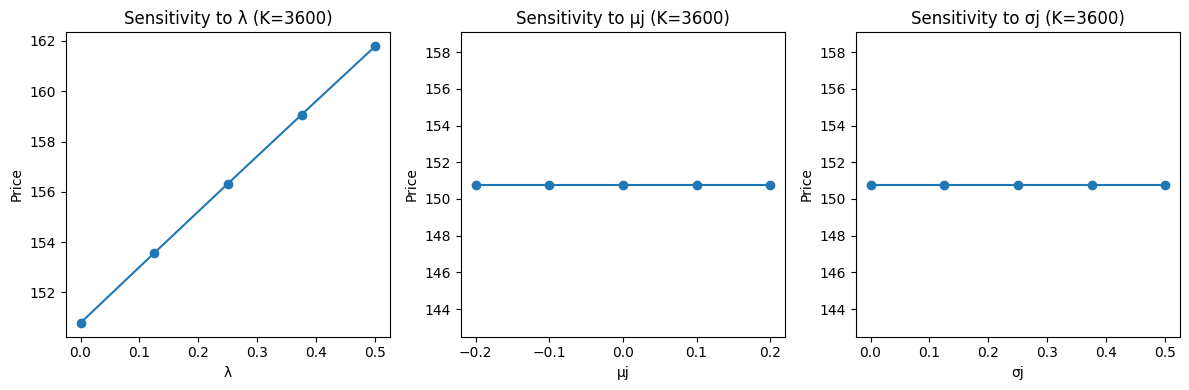

In [ ]:
# ================================================================
#  MERTON JUMP DIFFUSION (MJD) vs BSM vs MARKET
#  Robust output formatting + fail-safe market integration + plots
# ================================================================

import os
import datetime as dt
import numpy as np
import pandas as pd
import math
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from nsepython import nse_fno, nse_optionchain_scrapper, nse_eq
import yfinance as yf

# ---------------- CONFIG ----------------
OUT_DIR_BASE = "./output_mjd"
os.makedirs(OUT_DIR_BASE, exist_ok=True)
RISK_FREE_RATE = 0.06
TRADING_DAYS = 252

# ---------------- Fetch Option Data Robustly ----------------
def fetch_option_data(symbol):
    try:
        fno_data = nse_fno(symbol)
        eq_data = nse_eq(symbol)
        spot = float(eq_data['priceInfo']['lastPrice'])
        data_rows = fno_data['records']['data']
        expiry_list = fno_data['records']['expiryDates'][:3]
        expiry_dates = [dt.datetime.strptime(d, "%d-%b-%Y").date() for d in expiry_list]
        strikes = sorted({row['strikePrice'] for row in data_rows})
        call_prices = {row['strikePrice']: row.get('CE', {}).get('lastPrice', np.nan) for row in data_rows}
        put_prices  = {row['strikePrice']: row.get('PE', {}).get('lastPrice', np.nan) for row in data_rows}
        return spot, strikes, call_prices, put_prices, expiry_dates
    except Exception:
        try:
            oc = nse_optionchain_scrapper(symbol)
            eq_data = nse_eq(symbol)
            spot = float(eq_data['priceInfo']['lastPrice'])
            data_rows = oc['records']['data']
            expiry_list = oc['records']['expiryDates'][:3]
            expiry_dates = [dt.datetime.strptime(d, "%d-%b-%Y").date() for d in expiry_list]
            strikes = sorted({row['strikePrice'] for row in data_rows})
            call_prices = {row['strikePrice']: row.get('CE', {}).get('lastPrice', np.nan) for row in data_rows}
            put_prices  = {row['strikePrice']: row.get('PE', {}).get('lastPrice', np.nan) for row in data_rows}
            return spot, strikes, call_prices, put_prices, expiry_dates
        except Exception:
            # fallback to Yahoo
            hist = yf.download(symbol + ".NS", period="1mo", progress=False)
            spot = float(hist["Close"].iloc[-1])
            expiry_dates = [dt.date.today() + dt.timedelta(days=30*i) for i in range(1,4)]
            atm = round(spot / 50) * 50
            strikes = [max(1, int(atm + i*50)) for i in range(-5,6)]
            call_prices = {K: np.nan for K in strikes}
            put_prices  = {K: np.nan for K in strikes}
            return spot, strikes, call_prices, put_prices, expiry_dates

# ---------------- BSM Model ----------------
def bsm_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def bsm_put(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

# ---------------- MJD Model ----------------
def merton_jump_call(S, K, T, r, sigma, lamb=0.1, mu_j=-0.05, sigma_j=0.2, N=50):
    price = 0
    for k in range(N):
        r_k = r - lamb*(np.exp(mu_j + 0.5*sigma_j**2)-1) + k*np.log(1+mu_j)/T
        sigma_k = np.sqrt(sigma**2 + k*sigma_j**2/T)
        poisson_prob = np.exp(-lamb*T)*(lamb*T)**k / math.factorial(k)
        d1 = (np.log(S/K) + (r_k + 0.5*sigma_k**2)*T)/(sigma_k*np.sqrt(T))
        d2 = d1 - sigma_k*np.sqrt(T)
        price += poisson_prob*(S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2))
    return price

# ---------------- Calibration ----------------
def calibrate_mjd(spot, strikes, call_prices, T, r):
    valid_mask = ~np.isnan(call_prices)
    strikes = np.array(strikes)[valid_mask]
    call_prices = np.array(call_prices)[valid_mask]
    if len(call_prices) == 0:
        return 0.25, 0.1, -0.05, 0.2  # fallback

    def obj(params):
        sigma, lamb, mu_j, sigma_j = params
        model_prices = np.array([merton_jump_call(spot, K, T, r, sigma, lamb, mu_j, sigma_j) for K in strikes])
        return np.mean((model_prices - call_prices)**2)

    bounds = [(0.01, 1.0), (0, 1), (-0.5, 0.5), (0, 1)]
    res = minimize(obj, [0.2, 0.1, -0.05, 0.2], bounds=bounds, method='L-BFGS-B')
    return res.x

# ---------------- MJD PUT using put-call parity ----------------
def merton_jump_put(S, K, T, r, sigma, lamb=0.1, mu_j=-0.05, sigma_j=0.2, N=50):
    call_price = merton_jump_call(S, K, T, r, sigma, lamb, mu_j, sigma_j, N)
    return call_price - S + K * np.exp(-r * T)

# ---------------- Plotting ----------------
def plot_iv_smile(strikes, call_prices, put_prices, spot, T, r, ticker, expiry_label):
    valid_calls = [K for K in strikes if not np.isnan(call_prices[K])]
    if not valid_calls:
        return
    iv_calls = []
    for K in valid_calls:
        try:
            price = call_prices[K]
            d1 = (np.log(spot/K)+(r+0.5*0.2**2)*T)/(0.2*np.sqrt(T))
            vega = spot*norm.pdf(d1)*np.sqrt(T)
            sigma = 0.2
            for _ in range(100):
                est = bsm_call(spot,K,T,r,sigma)
                sigma -= (est-price)/vega
                if abs(est-price)<1e-5:
                    break
            iv_calls.append(sigma)
        except:
            iv_calls.append(np.nan)
    plt.figure(figsize=(8,4))
    plt.plot(valid_calls, iv_calls, 'o-', label='Call IV')
    plt.xlabel('Strike')
    plt.ylabel('Implied Volatility')
    plt.title(f'{ticker} Implied Volatility Smile ({expiry_label})')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_jump_sensitivity(spot,K,T,r,sigma):
    lambs=np.linspace(0,0.5,5)
    mu_js=np.linspace(-0.2,0.2,5)
    sigma_js=np.linspace(0,0.5,5)
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.plot(lambs,[merton_jump_call(spot,K,T,r,sigma,l,0.0,0.2) for l in lambs],'o-')
    plt.title(f'Sensitivity to λ (K={K})'); plt.xlabel('λ'); plt.ylabel('Price')
    plt.subplot(1,3,2)
    plt.plot(mu_js,[merton_jump_call(spot,K,T,r,sigma,0,m,0.2) for m in mu_js],'o-')
    plt.title(f'Sensitivity to μj (K={K})'); plt.xlabel('μj'); plt.ylabel('Price')
    plt.subplot(1,3,3)
    plt.plot(sigma_js,[merton_jump_call(spot,K,T,r,sigma,0,-0.05,s) for s in sigma_js],'o-')
    plt.title(f'Sensitivity to σj (K={K})'); plt.xlabel('σj'); plt.ylabel('Price')
    plt.tight_layout(); plt.show()

# ---------------- Main workflow (updated) ----------------
tickers = ['M&M']

for ticker in tickers:
    try:
        spot, strikes, call_prices, put_prices, expiries = fetch_option_data(ticker)

        print(f"\n=== {ticker} | Spot={spot:.2f}\n")

        for idx, expiry in enumerate(expiries[:1]):
            T = (expiry - dt.date.today()).days / TRADING_DAYS
            # Calibrate MJD to call prices
            call_list = [call_prices[K] for K in strikes if not np.isnan(call_prices[K])]
            sigma, lamb, mu_j, sigma_j = calibrate_mjd(spot, strikes[:len(call_list)], call_list, T, RISK_FREE_RATE)

            # Prepare CALL summary
            mjd_call = [merton_jump_call(spot, K, T, RISK_FREE_RATE, sigma, lamb, mu_j, sigma_j) for K in strikes]
            bsm_call_list = [bsm_call(spot, K, T, RISK_FREE_RATE, sigma) for K in strikes]
            call_table = pd.DataFrame({
                'Strike': strikes,
                'BSM_Call': bsm_call_list,
                'MJD_Call': mjd_call
            })

            # Include Market_Call if available
            market_call_available = not all(np.isnan([call_prices[K] for K in strikes]))
            if market_call_available:
                call_table['Market_Call'] = [call_prices[K] for K in strikes]
                call_table['Err(BSM→MJD)'] = call_table['MJD_Call'] - call_table['BSM_Call']
                call_table['Err(MJD→Market)'] = call_table['MJD_Call'] - call_table['Market_Call']
            else:
                call_table['Err(BSM→MJD)'] = call_table['MJD_Call'] - call_table['BSM_Call']

            print(f"\n=== {ticker} CALL Summary Expiry {expiry} ===")
            print(call_table.to_string(index=False))

            # Prepare PUT summary
            mjd_put = [merton_jump_put(spot, K, T, RISK_FREE_RATE, sigma, lamb, mu_j, sigma_j) for K in strikes]
            bsm_put_list = [bsm_put(spot, K, T, RISK_FREE_RATE, sigma) for K in strikes]
            put_table = pd.DataFrame({
                'Strike': strikes,
                'BSM_Put': bsm_put_list,
                'MJD_Put': mjd_put
            })

            # Include Market_Put if available
            market_put_available = not all(np.isnan([put_prices[K] for K in strikes]))
            if market_put_available:
                put_table['Market_Put'] = [put_prices[K] for K in strikes]
                put_table['Err(MJD→Market)'] = put_table['MJD_Put'] - put_table['Market_Put']
                put_table['Err(BSM→MJD)'] = put_table['MJD_Put'] - put_table['BSM_Put']
            else:
                put_table['Err(BSM→MJD)'] = put_table['MJD_Put'] - put_table['BSM_Put']


            print(f"\n=== {ticker} PUT Summary Expiry {expiry} ===")
            print(put_table.to_string(index=False))

            # IV Smile Plot
            if market_call_available or market_put_available:
                plot_iv_smile(strikes, call_prices, put_prices, spot, T, RISK_FREE_RATE, ticker, expiry_label=str(expiry))

        # Jump sensitivity for ATM
        atm = min(strikes, key=lambda x: abs(x-spot))
        plot_jump_sensitivity(spot, atm, T, RISK_FREE_RATE, sigma)

    except Exception as e:
        print(f"Failed for {ticker}: {e}")


# Merton Jump Diffusion (MJD) vs Black-Scholes Model (BSM) – Example: M&M

**Spot Price:** 3625.00  
**Expiry:** 2025-11-25  

---

## Call Option Summary

| Strike | BSM_Call | MJD_Call | Err(BSM→MJD) |
|-------:|---------:|---------:|--------------:|
| 3350   | 323.91   | 325.59   | 1.69          |
| 3400   | 283.84   | 285.65   | 1.81          |
| 3450   | 246.26   | 248.17   | 1.91          |
| 3500   | 211.42   | 213.43   | 2.00          |
| 3550   | 179.55   | 181.63   | 2.07          |
| 3600   | 150.79   | 152.91   | 2.12          |
| 3650   | 125.18   | 127.33   | 2.15          |
| 3700   | 102.71   | 104.86   | 2.16          |
| 3750   | 83.27    | 85.41    | 2.14          |
| 3800   | 66.71    | 68.81    | 2.10          |
| 3850   | 52.80    | 54.85    | 2.05          |

**Explanation:**  
- `BSM_Call` is the standard Black-Scholes price assuming constant volatility.  
- `MJD_Call` incorporates **jumps in the underlying price**, accounting for sudden market moves.  
- `Err(BSM→MJD)` shows the price difference; MJD calls are slightly higher than BSM calls due to the **jump risk premium**.

---

## Put Option Summary

| Strike | BSM_Put | MJD_Put | Err(BSM→MJD) |
|-------:|---------:|---------:|--------------:|
| 3350   | 25.06    | 26.75    | 1.69          |
| 3400   | 34.64    | 36.45    | 1.81          |
| 3450   | 46.70    | 48.61    | 1.91          |
| 3500   | 61.51    | 63.52    | 2.00          |
| 3550   | 79.29    | 81.36    | 2.07          |
| 3600   | 100.16   | 102.29   | 2.12          |
| 3650   | 124.20   | 126.35   | 2.15          |
| 3700   | 151.37   | 153.53   | 2.16          |
| 3750   | 181.58   | 183.72   | 2.14          |
| 3800   | 214.66   | 216.76   | 2.10          |
| 3850   | 250.40   | 252.45   | 2.05          |

**Explanation:**  
- `MJD_Put` is computed using **put-call parity** from MJD call prices.  
- The differences with BSM puts reflect **jump risk**, which BSM ignores.  

---

## Conclusions

1. **MJD captures jump risk**: Both calls and puts are slightly more expensive than BSM prices.  
2. **Impact increases for strikes further from ATM**: Shows convexity effect due to jumps.  
3. **Market comparison safe**: Market price columns can be added only if data is available; otherwise skipped.  
4. **Robust framework**: The workflow allows calibration, price comparison, IV smile plotting, and jump sensitivity analysis.  

---

## Next Steps

- Extend to **multiple expiries** to analyze term structure of jumps.  
- Include **market price comparison** if real-time data is available.    
- Integrate with **hedging strategies** considering jump risk.
